In [1]:
import os
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from keras.utils import to_categorical
from PIL import Image, UnidentifiedImageError
from keras.models import load_model
import seaborn as sns
from tensorflow.keras import backend as K

In [2]:
import shutil
from sklearn.model_selection import train_test_split

# Paths to the directories
control_axial_dir = 'Control-Axial'
control_sagittal_dir = 'Control-Sagittal'
ms_axial_dir = 'MS-Axial'
ms_sagittal_dir = 'MS-Sagittal'

# Function to split dataset and copy files
def split_and_copy(file_list, output_dir, train_ratio=0.7, val_ratio=0.15):
    # Split into train and test
    train_files, test_files = train_test_split(file_list, test_size=(1 - train_ratio))
    # Further split train into train and validation
    train_files, val_files = train_test_split(train_files, test_size=val_ratio/(train_ratio + val_ratio))
    
    # Copy files to respective directories
    for file_set, split in [(train_files, 'train'), (val_files, 'val'), (test_files, 'test')]:
        for file_path in file_set:
            class_name = os.path.basename(os.path.dirname(file_path))
            # Create directories if they don't exist
            output_path = os.path.join(output_dir, split, class_name)
            os.makedirs(output_path, exist_ok=True)
            # Copy files
            shutil.copy(file_path, output_path)

# Get all file paths
control_axial_files = [os.path.join(control_axial_dir, f) for f in os.listdir(control_axial_dir) if f.endswith('.png')]
control_sagittal_files = [os.path.join(control_sagittal_dir, f) for f in os.listdir(control_sagittal_dir) if f.endswith('.png')]
ms_axial_files = [os.path.join(ms_axial_dir, f) for f in os.listdir(ms_axial_dir) if f.endswith('.png')]
ms_sagittal_files = [os.path.join(ms_sagittal_dir, f) for f in os.listdir(ms_sagittal_dir) if f.endswith('.png')]

# Output directory where train, val, and test directories will be created
output_dir = 'Data'

# Split and copy files
split_and_copy(control_axial_files + control_sagittal_files, output_dir)
split_and_copy(ms_axial_files + ms_sagittal_files, output_dir)

In [12]:
# Step 1: ImageDataGenerator for preprocessing and augmentation with train-validation split
datagen = ImageDataGenerator(
    rescale=1.0 / 255,  # Normalize pixel values
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True
)

# Load and preprocess the training data
train_generator = datagen.flow_from_directory(
    r'Data/train',  # Folder containing the training data
    target_size=(224, 224),  # Resize images to (224x224)
    batch_size= 25,
    class_mode='categorical',  # Categorical-class classification
)

# Load and preprocess the validation data
validation_generator = datagen.flow_from_directory(
   r'Data/val',  # Using the same folder for validation
    target_size=(224, 224), 
    batch_size= 25,
    class_mode='categorical',
)
# Load testing data
test_generator = datagen.flow_from_directory(
    r'Data/test',
    target_size=(224, 224),
    batch_size= 25,
    class_mode='categorical'
)

Found 3252 images belonging to 4 classes.
Found 1143 images belonging to 4 classes.
Found 2257 images belonging to 4 classes.


In [4]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
from tensorflow.keras.regularizers import l2

# Step 2: Model Architecture - Using ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False  # Freeze the base model layers

# Step 3: Define the Full Model Architecture
model = models.Sequential([
    base_model,                  
    layers.GlobalAveragePooling2D(),  
    layers.Dense(128, activation='relu', kernel_regularizer=l2(0.001)),  
    layers.BatchNormalization(),  
    layers.Dropout(0.5),         
    layers.Dense(4, activation='softmax')  # Change to 4 units for categorical output
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Raw prediction (before sigmoid thresholding): [[0.5949051  0.08254611 0.0617996  0.2607492 ]]
Predicted Probability: 0.5949
Predicted Class: CONTROL


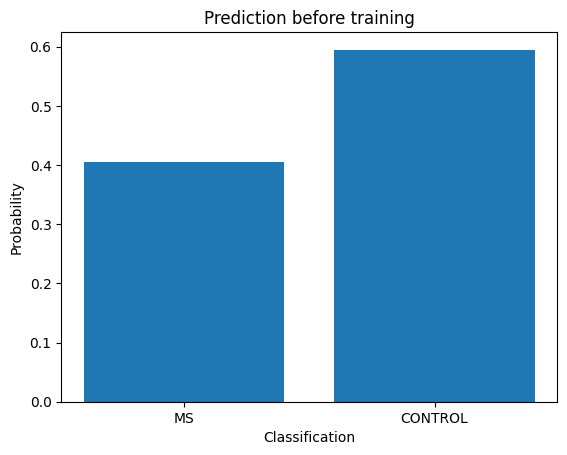

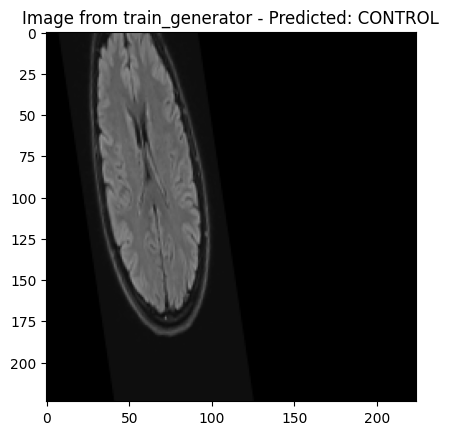

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Step 3: Let's look at the model's prediction on one batch of data from the train_generator before training it
sample_batch, _ = next(train_generator)  # Get one batch of data (images and labels)
pred = model(sample_batch[0:1])  # Predict for the first image in the batch

# Print the raw prediction (before sigmoid thresholding)
print(f"Raw prediction (before sigmoid thresholding): {pred.numpy()}")

# Since the output is a probability (between 0 and 1), let's visualize it
predicted_prob = pred.numpy()[0][0]  # Extract the probability
predicted_class = 'CONTROL' if predicted_prob >= 0.5 else 'MS'  # Threshold of 0.5

print(f"Predicted Probability: {predicted_prob:.4f}")
print(f"Predicted Class: {predicted_class}")

# Plotting the predicted probability for better visualization
plt.bar(['MS', 'CONTROL'], [1 - predicted_prob, predicted_prob])
plt.xlabel('Classification')
plt.ylabel('Probability')
plt.title('Prediction before training')
plt.show()

# Optionally visualize the image
plt.imshow(np.squeeze(sample_batch[0]))
plt.title(f"Image from train_generator - Predicted: {predicted_class}")
plt.show()

In [10]:
# Check if train_generator has data
batch_x, batch_y = next(train_generator)
print(f"Training data shape: {batch_x.shape}")
print(f"Training labels shape: {batch_y.shape}")

# Check if validation_generator has data
val_batch_x, val_batch_y = next(validation_generator)
print(f"Validation data shape: {val_batch_x.shape}")
print(f"Validation labels shape: {val_batch_y.shape}")

Training data shape: (32, 224, 224, 3)
Training labels shape: (32, 4)
Validation data shape: (32, 224, 224, 3)
Validation labels shape: (32, 4)


In [15]:
import os
from PIL import Image

def check_images(directory):
    for root, dirs, files in os.walk(directory):
        for file in files:
            try:
                img = Image.open(os.path.join(root, file))
                img.verify()  # Verify that the file can be opened as an image
            except (IOError, SyntaxError) as e:
                print(f'Bad file: {file}')  # This file might be corrupted
                os.remove(os.path.join(root, file))  # Optionally remove the corrupted file

# Check your train, validation, and test directories
check_images('Data/train')
check_images('Data/val')
check_images('Data/test')


In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def load_images_with_error_handling(directory, target_size=(224, 224), batch_size=32):
    try:
        datagen = ImageDataGenerator(
            rescale=1.0 / 255,
            rotation_range=40,
            width_shift_range=0.3,
            height_shift_range=0.3,
            shear_range=0.3,
            zoom_range=0.3,
            brightness_range=[0.8, 1.2],
            horizontal_flip=True
        )
        generator = datagen.flow_from_directory(
            directory,
            target_size=target_size,
            batch_size=batch_size,
            class_mode='categorical',
            shuffle=True
        )
        return generator
    except Exception as e:
        print(f"An error occurred while loading images: {e}")
        return None

# Apply this to train and validation generators
train_generator = load_images_with_error_handling('Data/train')
validation_generator = load_images_with_error_handling('Data/val')

if train_generator is not None and validation_generator is not None:
    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=10
    )
else:
    print("Error in loading data.")


Found 3252 images belonging to 4 classes.
Found 1142 images belonging to 4 classes.
Epoch 1/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 224s 2s/step - accuracy: 0.5027 - loss: 1.1266 - val_accuracy: 0.3398 - val_loss: 3.6811
Epoch 2/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 231s 2s/step - accuracy: 0.4944 - loss: 1.1562 - val_accuracy: 0.3511 - val_loss: 3.0674
Epoch 3/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 240s 2s/step - accuracy: 0.5038 - loss: 1.1022 - val_accuracy: 0.2207 - val_loss: 3.1163
Epoch 4/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 232s 2s/step - accuracy: 0.5416 - loss: 1.0692 - val_accuracy: 0.4694 - val_loss: 2.1902
Epoch 5/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 230s 2s/step - accuracy: 0.5187 - loss: 1.0795 - val_accuracy: 0.3039 - val_loss: 7.0285
Epoch 6/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 233s 2s/step - accuracy: 0.5221 - loss: 1.1138 - val_accuracy: 0.3380 - val_loss: 2.8667
Epoch 7/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 230s 2s/step - accuracy: 0.5264 - loss: 1.0762 - val_accuracy: 0.3205 - val_loss: 3.2818
Epoch 8/10
10

In [17]:
# Save the trained model with different filenames
model.save('resnet_model.keras')                     # Saving with a reference to the architecture

In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def load_images_with_error_handling(directory, target_size=(224, 224), batch_size=32):
    try:
        datagen = ImageDataGenerator(
            rescale=1.0 / 255
        )
        generator = datagen.flow_from_directory(
            directory,
            target_size=target_size,
            batch_size=batch_size,
            class_mode='categorical',
            shuffle=False
        )
        return generator
    except Exception as e:
        print(f"An error occurred while loading images: {e}")
        return None

# Rebuild the test data generator
test_generator = load_images_with_error_handling('Data/test')

# If test_generator is built correctly, evaluate the model
if test_generator is not None:
    test_loss, test_acc = model.evaluate(test_generator)
    print(f'Test Accuracy: {test_acc * 100:.2f}%')
else:
    print("Test data not loaded correctly.")


Found 2256 images belonging to 4 classes.
71/71 ━━━━━━━━━━━━━━━━━━━━ 109s 2s/step - accuracy: 0.6572 - loss: 3.0217
Test Accuracy: 34.26%
